In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as T
import os
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        # Convert to grayscale ('L' mode)
        image = Image.open(image_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# train_vae.py


# Specify the path you want to change to
new_directory = "/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff"

# Change the current working directory
os.chdir(new_directory)

# Confirm the directory has changed
print("Current Directory:", os.getcwd())

from vae_model import VAE  # The combined VAE from above

def evaluate(model, dataloader, device):
    """
    Evaluate model on the entire dataloader, returning the average VAE loss.
    """
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            recon, mu, logvar = model(images)
            loss = vae_loss_function(recon, images, mu, logvar)
            total_loss += loss.item() * images.size(0)
            count += images.size(0)

    avg_loss = total_loss / count
    return avg_loss

########################################
# 1. Define your VAE loss
########################################
def vae_loss_function(recon_x, x, mu, logvar):
    """
    Standard VAE Loss = MSE reconstruction + KL divergence.
    You can also switch to L1 or BCE for recon, depending on your data range.
    """
    # Reconstruction loss (MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')

    # KL Divergence
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    # We'll reduce (mean) across all batch pixels
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld

########################################
# 2. Main training loop
########################################
def train_vae(
    data_root,
    num_epochs,
    batch_size,
    lr,
    momentum,
    image_size,
    device
):

    # 2.1 Build transforms and dataset
    transform = T.Compose([
        T.Grayscale(num_output_channels=1),
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
        # Optionally T.Normalize([0.5], [0.5]) if you want [-1,1] range.
    ])
    dataset = ImageDataset(image_dir=data_root, transform=transform)

    overall_ratio = 1.0

    subset_indices = random.sample(range(len(dataset)), int(len(dataset) * overall_ratio))
    sub_dataset = Subset(dataset, subset_indices)

    train_ratio = 0.5

    train_len = int(len(sub_dataset) * train_ratio)
    val_len = len(sub_dataset) - train_len
    train_dataset, val_dataset = random_split(sub_dataset, [train_len, val_len])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model_path = '/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/vae_models/best_model-epoch_5-loss_0.003076.pth'

    # 2.2 Initialize model and optimizer
    model = VAE().to(device)

    # if os.path.exists(model_path):
    #     print("\nsuccessfully loaded model\n")
    #     model.load_state_dict(torch.load(model_path, map_location=device))

    cur_lr = prev_lr = lr
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # best_loss = 0.003076
    best_loss = float('inf')
    best_model_weights = model.state_dict().copy()


    # These counters control reverting weights (mini-patience)
    # and early stopping (full patience)
    early_stopping = 0
    mini_patience = 3   # revert to best weights if no improvement for 3 consecutive epochs
    full_patience = 10  # stop training if no improvement for 10 consecutive epochs

    step = 0
    accumulation_steps = 10

    # 2.3 Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        loader = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)
        for images in loader:
            images = images.to(device)  # shape (N,1,H,W)

            step += 1

            # Forward pass
            recon, mu, logvar = model(images)

            # Compute loss
            loss = vae_loss_function(recon, images, mu, logvar)

            total_loss += loss.item() * images.size(0)

            # loss = loss / accumulation_steps

            # Backprop
            # optimizer.zero_grad()
            loss.backward()
            # optimizer.step()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                loss = loss / accumulation_steps
                optimizer.step()
                optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_dataloader.dataset)
        # Val loss
        val_loss = evaluate(model, val_dataloader, device)
        print(f"\nEpoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {avg_train_loss:.6f}  |  Val Loss: {val_loss:.6f}")

        # 2.4 Print average epoch loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict().copy()
            print("new best model saved")
            torch.save(model.state_dict(), f"/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/vae_models/best_model-epoch:{epoch}-loss:{val_loss:.6f}.pth")
            early_stopping = 0
        else:
            early_stopping += 1
            if early_stopping >= full_patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
            if early_stopping >= mini_patience:
                print(f"Reverting weights at epoch {epoch}")
                model.load_state_dict(best_model_weights)

        # LR scheduler
        scheduler.step(val_loss)
        cur_lr = scheduler.get_last_lr()[0]
        if cur_lr != prev_lr:
            print(f"Learning rate updated: {cur_lr}")
            prev_lr = cur_lr

    # 2.5 Save final model (optional)
    # torch.save(model.state_dict(), "train_vae/models")
    print("Training finished and model saved.")
    torch.save(model.state_dict(), f"/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/vae_models/best_model-epoch:{epoch}-loss:{best_loss:.6f}.pth")

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_vae(
        data_root="/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/complete_tdata/",
        num_epochs=25,
        batch_size=5,
        lr=1e-4,
        momentum=0.9,
        image_size=256,
        device=device
    )


Current Directory: /storage/ice1/6/7/dharden7/sd_proj/sd/Stable_diff/training_files

Model loaded successfully.



/tmp/ipykernel_3240678/745586884.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Reconstruction stats: -0.637008786201477 0.6117766499519348 0.026952382177114487


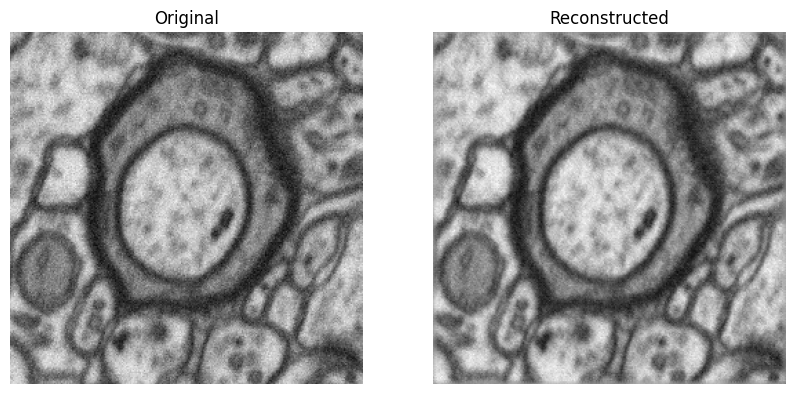

In [9]:
import random
import matplotlib.pyplot as plt
import torch

new_directory = "/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/training_files/"

# Change the current working directory
os.chdir(new_directory)

# Confirm the directory has changed
print("Current Directory:", os.getcwd())

image_size = 256

transform = T.Compose([
        T.Grayscale(num_output_channels=1),
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
        # Optionally T.Normalize([0.5], [0.5]) if you want [-1,1] range.
    ])

from vae_model import VAE  # The combined VAE from above

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# dataset = ImageDataset(image_dir=f'/content/drive/MyDrive/Stable_diff/complete_tdata/expanded_dataset', transform=transform)

# Overfitting
dataset = ImageDataset(image_dir=f'/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/complete_tdata/', transform=transform)

model_path = '/home/hice1/dharden7/scratch/sd_proj/sd/Stable_diff/vae_models/best_model-epoch_5-loss_0.003076.pth'

model = VAE()

if os.path.exists(model_path):
    print('\nModel loaded successfully.\n')
    model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)

# Let's assume:
# - you have a 'dataset' that returns a single image each time
# - your 'model' (VAE) is loaded with trained weights
# - device = 'cuda' or 'cpu'

# 1. Pick a random index from the dataset
# idx = random.randint(0, len(dataset) - 1)
idx = 555

# 2. Retrieve the image (shape: (1, H, W) if grayscale)
original_image = dataset[idx]  # might be (C,H,W), depends on how your dataset is coded

# 3. Send to device and expand batch dimension (N=1)
model.eval()
with torch.no_grad():
    # original_image might be a Tensor of shape (1,H,W). If it's (H,W), wrap or fix dims.
    x = original_image.unsqueeze(0).to(device)  # shape (1,1,H,W)
    recon, mu, logvar = model(x)
    # shape of recon is (1,1,H,W)
    print("Reconstruction stats:",
      recon.min().item(),
      recon.max().item(),
      recon.mean().item())


# 4. Convert to CPU for plotting
x_orig = x.squeeze(0).cpu()     # shape (1,H,W)
x_recon = recon.squeeze(0).cpu() # shape (1,H,W)

# 5. Plot side by side
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Original")
# If it's single-channel, pick [0] as the channel dimension, and use cmap='gray'
plt.imshow(x_orig[0], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(x_recon[0], cmap='gray')
plt.axis('off')

plt.show()
